# Diabetes Prediction using Classical Machine Learning Approaches

In [4]:
import os
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)


In [5]:
## 📦 Dataset Download
# This notebook automatically downloads the dataset.
# No manual upload or Google Drive access required.

FILE_ID = "1pijc4OZkCBEWJTdYL3iCun6mKakoZmaC"
URL = f"https://drive.google.com/uc?id={FILE_ID}"
OUTPUT = "data.csv"

if not os.path.exists(OUTPUT):
    print("⬇️ Downloading dataset...")
    gdown.download(URL, OUTPUT, quiet=False)
else:
    print("✅ Dataset already exists")

df = pd.read_csv(OUTPUT)
df.head()


⬇️ Downloading dataset...


Downloading...
From: https://drive.google.com/uc?id=1pijc4OZkCBEWJTdYL3iCun6mKakoZmaC
To: /content/data.csv
100%|██████████| 23.9k/23.9k [00:00<00:00, 27.1MB/s]


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
# Medical Range Filtering
# Remove physiologically implausible values to reduce noise
# Note: This may reduce dataset size but improves clinical validity
medical_ranges = {
    "Pregnancies": (0, 20),
    "Glucose": (70, 200),
    "BloodPressure": (40, 140),
    "SkinThickness": (5, 100),
    "Insulin": (15, 900),
    "BMI": (10, 60),
    "DiabetesPedigreeFunction": (0.05, 3.0),
    "Age": (18, 100)
}

for col, (low, high) in medical_ranges.items():
    df = df[(df[col] >= low) & (df[col] <= high)]


## Exploratory Data Analysis (EDA)
Visual analysis of feature distributions and relationships with diabetes outcome.


<Figure size 1200x800 with 0 Axes>

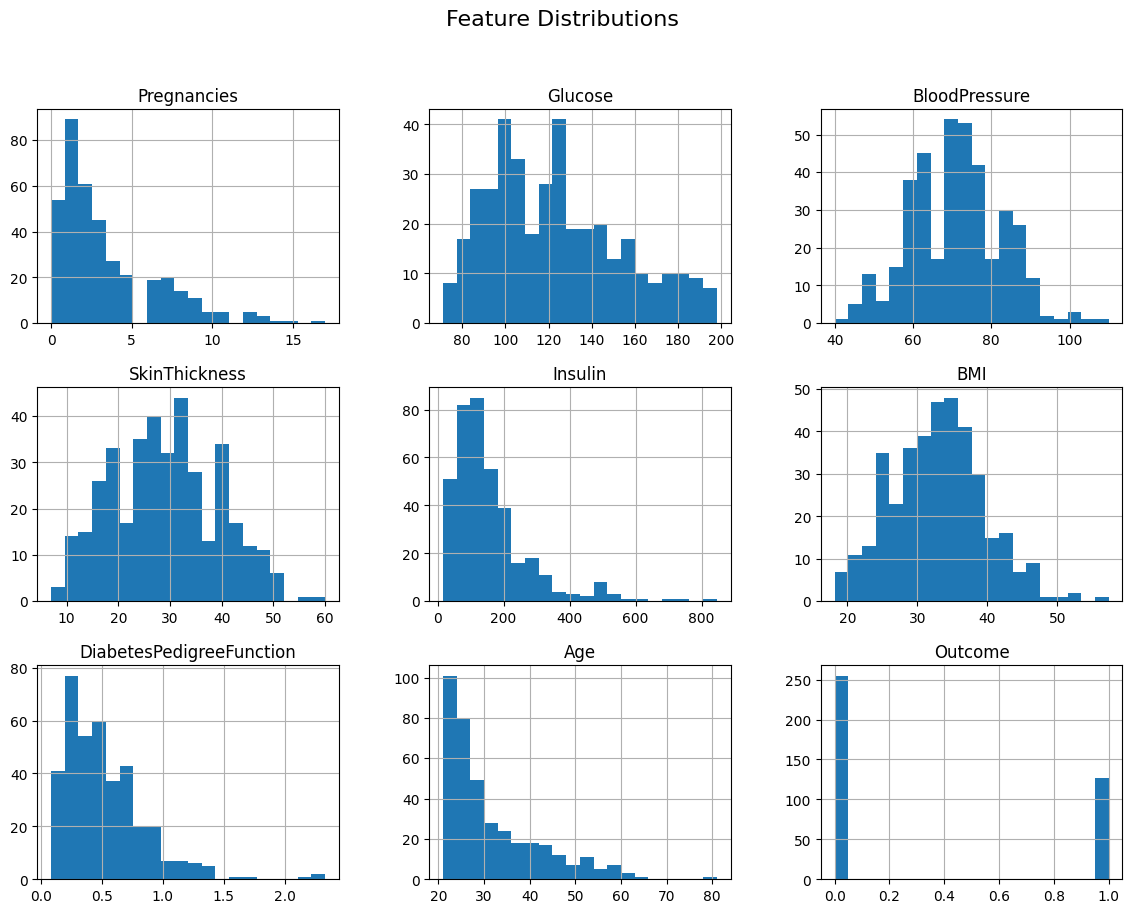

In [7]:
plt.figure(figsize=(12, 8))
df.hist(bins=20, figsize=(14, 10))
plt.suptitle('Feature Distributions', fontsize=16)
plt.show()


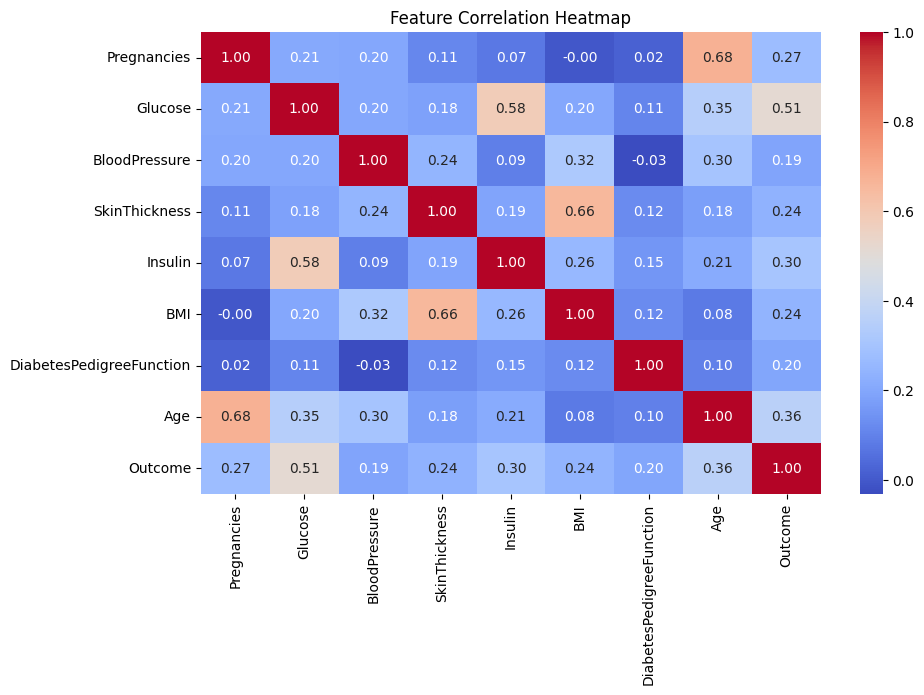

In [8]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()


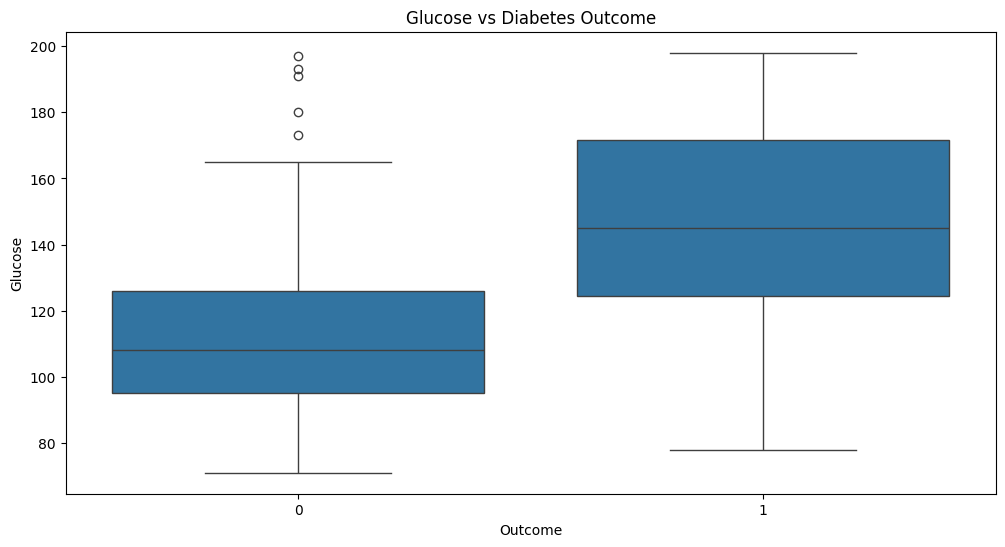

In [9]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Outcome', y='Glucose')
plt.title('Glucose vs Diabetes Outcome')
plt.show()


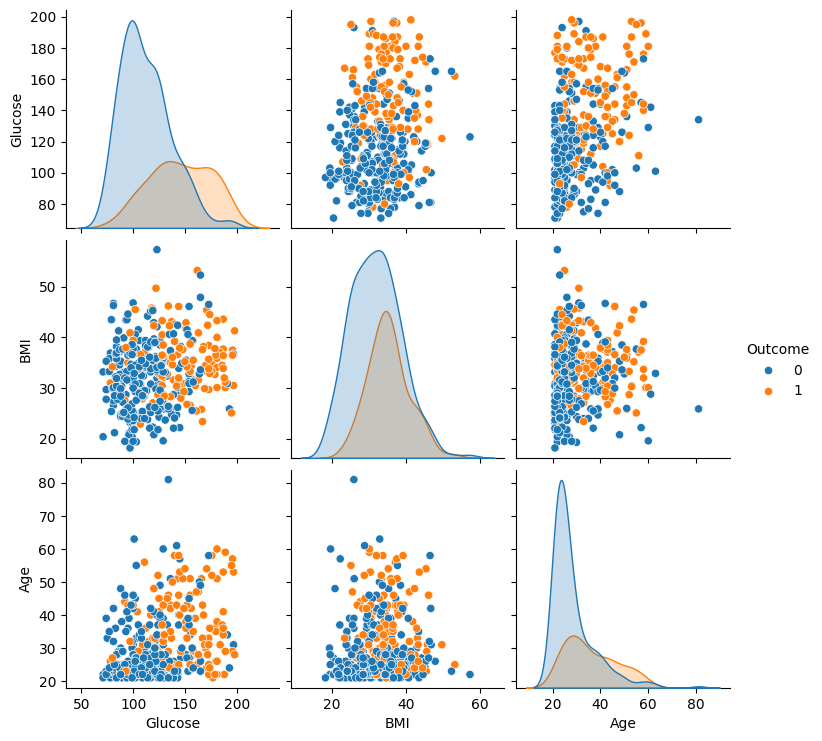

In [10]:
sns.pairplot(df[['Glucose', 'BMI', 'Age', 'Outcome']], hue='Outcome')
plt.show()


In [11]:
# Basic EDA
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
Index: 382 entries, 3 to 765
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               382 non-null    int64  
 1   Glucose                   382 non-null    int64  
 2   BloodPressure             382 non-null    int64  
 3   SkinThickness             382 non-null    int64  
 4   Insulin                   382 non-null    int64  
 5   BMI                       382 non-null    float64
 6   DiabetesPedigreeFunction  382 non-null    float64
 7   Age                       382 non-null    int64  
 8   Outcome                   382 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 29.8 KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000
mean,3.335079,123.329843,70.931937,29.065445,158.450262,32.956283,0.522484,30.955497,0.332461
std,3.215412,30.420088,11.607789,10.377566,119.275047,6.565615,0.334469,10.251463,0.471713
min,0.000000,71.000000,40.000000,7.000000,16.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,99.250000,62.500000,21.000000,78.250000,28.425000,0.270250,23.000000,0.000000
50%,2.000000,120.000000,70.000000,29.000000,127.500000,33.200000,0.452000,27.000000,0.000000
75%,5.000000,143.750000,78.000000,36.000000,191.750000,36.975000,0.687000,36.000000,1.000000
max,17.000000,198.000000,110.000000,60.000000,846.000000,57.300000,2.329000,81.000000,1.000000


In [12]:
# # KMeans-based Imputation (for large datasets)
# # Although this method is better for generalization or for larger datasets but it is computationally expensive.
# # So for current dataset (PIMA Indians Diabetes Dataset) it has been commented out to keep it simple and more accurate and to avoid overfitting.
# # It can be enabled for larger datasets where cluster-based patterns improve imputation quality.

# from sklearn.cluster import KMeans

# cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# df[cols_with_zero] = df[cols_with_zero].astype(float)

# df_kmeans = df.copy()
# df_kmeans[cols_with_zero] = df_kmeans[cols_with_zero].replace(0, np.nan)
# df_kmeans[cols_with_zero] = df_kmeans[cols_with_zero].fillna(
#     df_kmeans[cols_with_zero].mean()
# )

# kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
# df_kmeans['Cluster'] = kmeans.fit_predict(df_kmeans.drop('Outcome', axis=1))

# for col in cols_with_zero:
#     for cluster in df_kmeans['Cluster'].unique():
#         median_val = df_kmeans.loc[
#             df_kmeans['Cluster'] == cluster, col
#         ].median()
#         df.loc[
#             (df[col] == 0) & (df_kmeans['Cluster'] == cluster),
#             col
#         ] = float(median_val)

# Median Imputation (currently used instead of KMeans Imputation for better accuracy on smaller datasets)
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in cols_with_zero:
    df[col] = df[col].replace(0, df[col].median())


In [13]:
# Feature / target split
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [14]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [15]:
# Logistic Regression
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)
y_prob_lr = log_reg.predict_proba(X_test_scaled)[:, 1]


In [16]:
# LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train)
y_pred_lda = lda.predict(X_test_scaled)
y_prob_lda = lda.predict_proba(X_test_scaled)[:, 1]


In [17]:
# Evaluation function
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1-score:", f1_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

evaluate_model('Logistic Regression', y_test, y_pred_lr)
evaluate_model('LDA', y_test, y_pred_lda)



Logistic Regression
Accuracy: 0.7922077922077922
Precision: 0.6666666666666666
Recall: 0.7692307692307693
F1-score: 0.7142857142857143
Confusion Matrix:
 [[41 10]
 [ 6 20]]
              precision    recall  f1-score   support

           0       0.87      0.80      0.84        51
           1       0.67      0.77      0.71        26

    accuracy                           0.79        77
   macro avg       0.77      0.79      0.78        77
weighted avg       0.80      0.79      0.80        77


LDA
Accuracy: 0.7922077922077922
Precision: 0.7272727272727273
Recall: 0.6153846153846154
F1-score: 0.6666666666666666
Confusion Matrix:
 [[45  6]
 [10 16]]
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        51
           1       0.73      0.62      0.67        26

    accuracy                           0.79        77
   macro avg       0.77      0.75      0.76        77
weighted avg       0.79      0.79      0.79        77



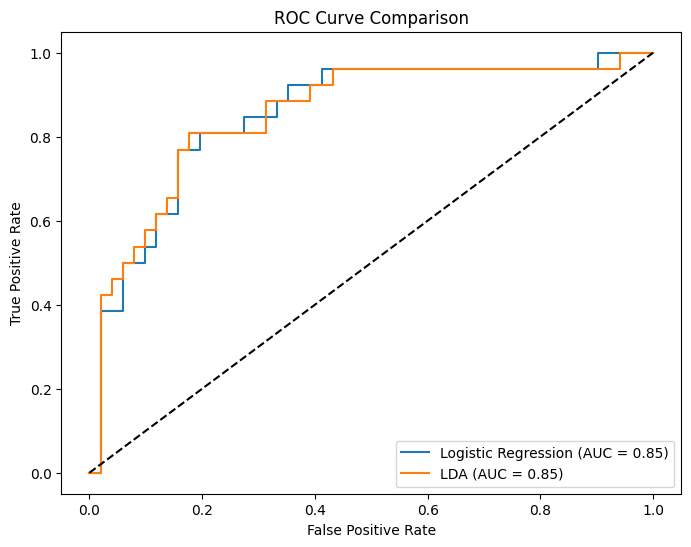

In [18]:
# ROC Curve comparison
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_lda, tpr_lda, _ = roc_curve(y_test, y_prob_lda)

roc_auc_lr = auc(fpr_lr, tpr_lr)
roc_auc_lda = auc(fpr_lda, tpr_lda)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_lda, tpr_lda, label=f'LDA (AUC = {roc_auc_lda:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


In [19]:
# Feature importance from Logistic Regression
feature_importance = pd.Series(
    log_reg.coef_[0], index=X.columns
).sort_values(key=abs, ascending=False)

feature_importance


,0
Glucose,1.162929
BMI,0.439254
DiabetesPedigreeFunction,0.429931
Age,0.275627
Pregnancies,0.173074
SkinThickness,0.163036
BloodPressure,0.078242
Insulin,0.061324


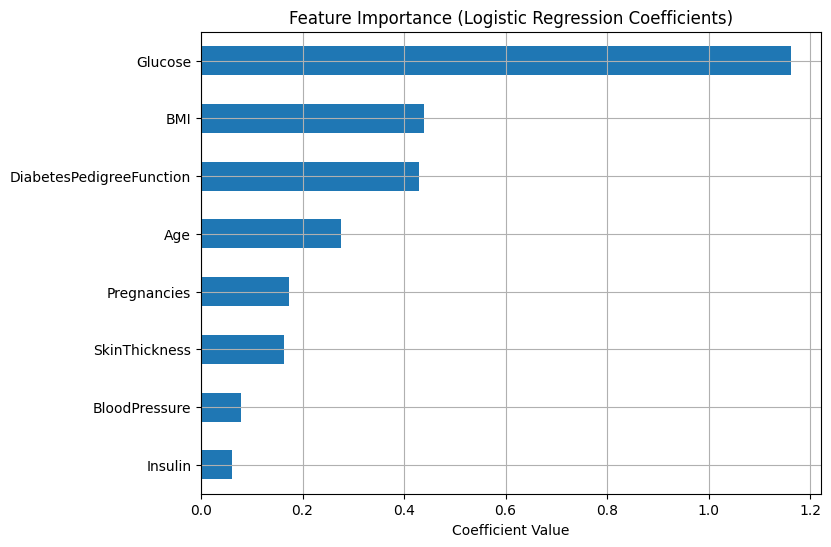

In [20]:
# Feature importance from Logistic Regression
feature_importance = pd.Series(
    log_reg.coef_[0],
    index=X.columns
).sort_values(key=abs, ascending=True)

plt.figure(figsize=(8, 6))
feature_importance.plot(kind="barh")

plt.xlabel("Coefficient Value")
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.grid(True)
plt.show()


## 🖥️ Streamlit Interactive UI (Optional)

This project also includes an interactive **Streamlit UI** for exploration.

### 🔹 Steps to Run Locally
1. Download the Streamlit app file:
   👉 https://drive.google.com/file/d/1LdK8CIqWjPSfZIWajwBYPbJTb7mzXbw4/view?usp=sharing

2. Place `app.py` in the **same directory** as this notebook.

3. Open terminal and run:
```bash
streamlit run app.py


## 🖼️ Optional UI Assets (Streamlit App)

The `app.py` file uses optional image assets to enhance UI/UX.

- The Streamlit app is **robust to missing image files** and will **run without errors** even if the images are not present.
- For the **best visual experience**, it is recommended to extract the provided ZIP file such that the `images/` folder is placed in the **root directory** alongside `app.py`.

📦 **Assets (ZIP)**  
👉 https://drive.google.com/file/d/15HGgILSRI2spVzQ2MElgAq0PSvOq_7EV/view?usp=sharing


## 📄 Project Deliverables

### 📘 Project Report
- **Google Docs (Primary)**  
  👉 https://docs.google.com/document/d/1HWpm_bQ5YelroV9gdvqP9RpXFSXmbIbNxppl-cGU-sA/edit?usp=drive_link

- **PDF (Alternate Format)**  
  👉 https://drive.google.com/file/d/1IIRVoBiis6ZUpJN3GCuZl1VzTy-m95wu/view?usp=sharing

### 🎤 Project Presentation
- **Presentation Slides (PDF/PPT)**  
  👉 https://drive.google.com/file/d/1eTtRSsks3ivb-8slklKonTVhCL1GgGZF/view?usp=sharing
  
> ℹ️ The Google Docs version contains the most up-to-date content.  
> The PDF is provided for offline viewing and archival purposes.
